In [344]:
import sys, os
import torch
from glue_preprocess import load_tsv
import numpy as np
import spacy
from tqdm import tqdm
root = "/Users/sebwagner/Documents/Grad_School/Rotations/Re/"
sys.path.append(root + "metal")
os.environ["GLUEDATA"] = root + "metal/metal/mmtl/glue/glue_data"
from metal.mmtl.metal_model import MetalModel, probs_to_preds
import metal.mmtl.glue.glue_datasets
import metal.mmtl.glue.glue_tasks
import torch.nn as nn
from torch.autograd import Variable
import torch
import json

In [345]:
with open(os.path.join(root+"dawn/", "config.json")) as f:
    task_config = json.load(f)
tasks, payloads = glue_tasks.create_glue_tasks_payloads(['RTE'], **task_config)
dataset = glue_datasets.get_glue_dataset('RTE','train',"bert-base-uncased")

Could not find kwarg "verbose" in destination dict.
Could not find kwarg "commit_hash" in destination dict.
Could not find kwarg "ami" in destination dict.
Could not find kwarg "progress_bar" in destination dict.
Could not find kwarg "n_epochs" in destination dict.
Could not find kwarg "l2" in destination dict.
Could not find kwarg "grad_clip" in destination dict.
Could not find kwarg "optimizer_config" in destination dict.
Could not find kwarg "lr_scheduler" in destination dict.
Could not find kwarg "lr_scheduler_config" in destination dict.
Could not find kwarg "metrics_config" in destination dict.
Could not find kwarg "task_scheduler" in destination dict.
Could not find kwarg "logger" in destination dict.
Could not find kwarg "logger_config" in destination dict.
Could not find kwarg "writer" in destination dict.
Could not find kwarg "writer_config" in destination dict.
Could not find kwarg "checkpoint" in destination dict.
Could not find kwarg "checkpoint_tasks" in destination dict.

In [3]:
def extract_features(dataset,nlp):
    sentences = dataset.sentences[:200]
    # Two 300 dimensional vectors
    features = np.zeros((len(sentences),600))
    # For now the only feature we extract is the GloVe vector representation of each sentence.
    for s_i in tqdm(range(len(sentences))):
        sentence_pair = sentences[s_i]
        for token in sentence_pair[0]:
            features[s_i,:300] += nlp(token).vector
        for token in sentence_pair[1]:
            features[s_i,300:] += nlp(token).vector
        features[s_i,:300] /= np.linalg.norm(features[s_i,:300])
        features[s_i,300:] /= np.linalg.norm(features[s_i,300:])
    return features

nlp = spacy.load("en_core_web_lg")
features = extract_features(dataset,nlp)

100%|██████████| 200/200 [05:47<00:00,  1.20s/it]


In [346]:
# Convert to boolean +- 1 representation
bool_features = features>0.01
bool_features = bool_features.astype(np.int)
bool_features[bool_features == 0] = -1

In [347]:
# I'm having issues loading the model using this value of tasks. What should I use here?
# model = MetalModel(tasks, verbose=False, device=-1)
# model_path = root + 'dawn/best_model.pth'
# model.load_weights(model_path)
# model.eval()

In [348]:
tsv_path = '/Users/sebwagner/Documents/Grad_School/Rotations/Re/dawn/train.tsv'
_, labels = load_tsv(tsv_path,1,2,3,1)
# Which label is 1 and 0? I guess 0 for not_entailment.
labels = list(map(lambda x: -1 if x == 'not_entailment' else 1, labels))[:200]
# For now we're going to create fake labels since we don't have the model outputs
fake_predicted_labels = np.array(labels)*bool_features[:,21]
dif_numpy =np.abs(fake_predicted_labels-labels)

In [349]:
# Build the linear classifier with L1 weight regularization.
class LinearRegression(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim,output_dim)
    
    def forward(self,X):
        X = self.linear(X)
        return X

In [354]:
# Initialize our model
linear_regression = LinearRegression(bool_features.shape[1],1)
X = Variable(torch.Tensor(bool_features))
dif = Variable(torch.Tensor(np.expand_dims(dif_numpy.T,axis=1)))
# Regularization strength of L1 norm:
lam = 1e-2

100%|██████████| 5000/5000 [00:02<00:00, 2088.26it/s]


tensor(0.0201, grad_fn=<AddBackward0>)


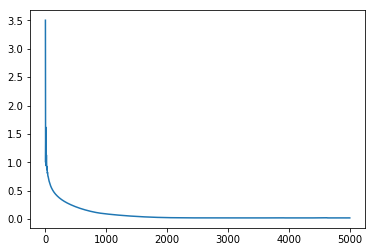

In [355]:
# Learn our weights
optim = torch.optim.Adam(linear_regression.parameters(), lr = 0.001)
linear_regression.train()
n_epochs = 5000
loss_vec = []
for epoch in tqdm(range(n_epochs)):
    dif_pred = linear_regression(X)
    pred_loss = nn.MSELoss()
    loss = pred_loss(dif_pred,dif)
    for param in linear_regression.parameters():
        loss += lam*torch.sum(torch.abs(param))
    loss_vec.append(loss.data.numpy())
    optim.zero_grad()
    loss.backward()
    optim.step()
plt.plot(np.array(loss_vec))
print(loss)

In [356]:
params = []
for param in linear_regression.parameters():
    params.append(param.data.numpy())
np.where(np.abs(params[0])>0.2)[1]

array([21])

### Questions
1. What changes do I need to make to have the model match the configuration for the model weights?
2. What types of features should I start exploring? Bag of words (best implementation of this? Just build a dictionairy from RTE sentences?)
3. What do we need the pipeline to look like to be useful? Take as input the model_path and configuration file and output the features that define the slices? How should we encode these features (I assume this depends on the features we want to extract).
4. How do we tune regularization strength and cutoff on weights?